In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

✅ Đã tải mô hình thành công!
Các quận hiện có trong mô hình: ['Huyện Hòa Vang', 'Quận Cẩm Lệ', 'Quận Hải Châu', 'Quận Liên Chiểu', 'Quận Ngũ Hành Sơn', 'Quận Sơn Trà', 'Quận Thanh Khê']
🔮 Đang dự báo giá cho Huyện Hòa Vang từ 2025-04-11 đến 2026-04-11...

📈 Kết quả dự báo:
        Ngày            Quận  Giá dự báo (đơn vị/m2)
0 2025-04-11  Huyện Hòa Vang               13.293835
1 2025-04-12  Huyện Hòa Vang               13.267830
2 2025-04-13  Huyện Hòa Vang               13.318153
3 2025-04-14  Huyện Hòa Vang               13.348727
4 2025-04-15  Huyện Hòa Vang               13.366375
5 2025-04-16  Huyện Hòa Vang               13.362819
6 2025-04-17  Huyện Hòa Vang               13.362819
7 2025-04-18  Huyện Hòa Vang               13.362819
8 2025-04-19  Huyện Hòa Vang               13.297056
9 2025-04-20  Huyện Hòa Vang               13.296045

✅ Đã lưu kết quả dự báo vào file: Huyện Hòa Vang_forecast_2025-04-11_to_2026-04-11.csv


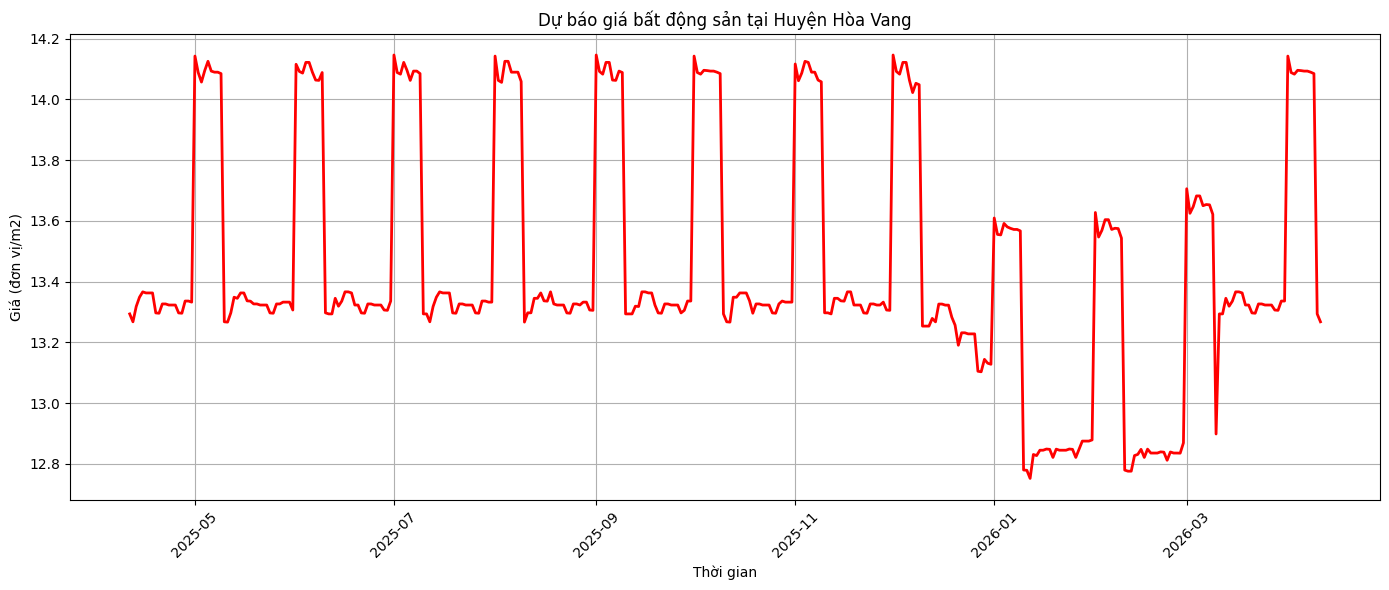

In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Hàm tạo các đặc trưng thời gian
def create_time_features(df):
    df_copy = df.copy()
    
    df_copy['year'] = df_copy['Posted Time'].dt.year
    df_copy['month'] = df_copy['Posted Time'].dt.month
    df_copy['day'] = df_copy['Posted Time'].dt.day
    df_copy['dayofweek'] = df_copy['Posted Time'].dt.dayofweek
    df_copy['quarter'] = df_copy['Posted Time'].dt.quarter
    df_copy['dayofyear'] = df_copy['Posted Time'].dt.dayofyear
    df_copy['is_weekend'] = df_copy['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
    df_copy['season'] = df_copy['month'].map(season_dict)
    
    min_date = pd.to_datetime('2024-01-01')
    df_copy['days_from_min'] = (df_copy['Posted Time'] - min_date).dt.days
    
    df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
    df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    
    return df_copy

# Hàm tạo đặc trưng lag và rolling
def create_lag_features(district_df, lag_days=[7, 14, 30], window_sizes=[7, 14, 30]):
    df_copy = district_df.copy()
    
    for lag in lag_days:
        df_copy[f'price_lag_{lag}'] = 0
    
    for window in window_sizes:
        df_copy[f'price_rolling_mean_{window}'] = 0
        df_copy[f'price_rolling_std_{window}'] = 0
    
    df_copy['price_diff_1'] = 0
    df_copy['price_diff_7'] = 0
    df_copy['price_pct_change_1'] = 0
    df_copy['price_pct_change_7'] = 0
    
    return df_copy

# Hàm đọc file scaler parameters và tính ngược scaling: original_value = scaled_value*(max-min) + min
def inverse_min_max(predictions, scaler_csv='predict_scaler_params.csv'):
    scaler_params = pd.read_csv(scaler_csv, index_col='Metric')
    min_val = scaler_params.loc['min', 'price']
    max_val = scaler_params.loc['max', 'price']
    # Áp dụng công thức nghịch đảo min-max scaling
    original_values = predictions * (max_val - min_val) + min_val
    return original_values

# Hàm dự báo cho tương lai
def forecast_future_prices(district_name, model_info, start_date, end_date):
    model = model_info['model']
    feature_columns = model_info['feature_columns']
    
    future_dates = pd.date_range(start=start_date, end=end_date)
    future_df = pd.DataFrame({'Posted Time': future_dates})
    future_df['District Name'] = district_name
    
    future_df = create_time_features(future_df)
    future_df = create_lag_features(future_df)
    
    X_future = future_df[feature_columns]
    
    # Dự báo (giá trị dự báo hiện tại là giá trị đã được scale)
    predictions_scaled = model.predict(X_future)
    
    # Nghịch đảo min-max scaling để có giá trị gốc
    predictions_original = inverse_min_max(predictions_scaled)
    
    result_df = pd.DataFrame({
        'Ngày': future_dates,
        'Quận': district_name,
        'Giá dự báo (đơn vị/m2)': predictions_original
    })
    
    return result_df

# Hàm vẽ biểu đồ dự báo
def plot_forecast(forecast_df, district_name):
    plt.figure(figsize=(14, 6))
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo (đơn vị/m2)'], 'r-', linewidth=2)
    plt.title(f'Dự báo giá bất động sản tại {district_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Chương trình chính
def main():
    try:
        with open('district_xgboost_models.pkl', 'rb') as f:
            district_models = pickle.load(f)
        print("✅ Đã tải mô hình thành công!")
    except Exception as e:
        print(f"❌ Lỗi khi tải mô hình: {e}")
        return
    
    available_districts = list(district_models.keys())
    print(f"Các quận hiện có trong mô hình: {available_districts}")
    
    district_name = available_districts[0]  # Chọn quận đầu tiên, bạn có thể thay đổi
    
    today = datetime.now()
    start_date = today.strftime('%Y-%m-%d')
    end_date = (today + timedelta(days=365)).strftime('%Y-%m-%d')
    
    print(f"🔮 Đang dự báo giá cho {district_name} từ {start_date} đến {end_date}...")
    
    forecast_result = forecast_future_prices(
        district_name,
        district_models[district_name],
        start_date,
        end_date
    )
    
    print("\n📈 Kết quả dự báo:")
    print(forecast_result.head(10))
    
    csv_filename = f"{district_name}_forecast_{start_date}_to_{end_date}.csv"
    forecast_result.to_csv(csv_filename, index=False)
    print(f"\n✅ Đã lưu kết quả dự báo vào file: {csv_filename}")
    
    plot_forecast(forecast_result, district_name)

if __name__ == "__main__":
    main()
